<br>

# Ripple-associated amplitude changes

The forth notebook is used to analyse putative ripple-associated CG amplitude changes (that is, during hippocampal ripple occurrence) in different task contexts. It does so by:

- Plotting the averaged amplitude (uV) before and after ripple occurrence during different task phases or contexts;
- Calculating the baselined voltage before and after ripple occurrence
- Plotting amplitude for all SWR events in a heatmap;
- Significance testing of observed changes to baseline. PENDING

<br>

### Imports

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy
from scipy.stats import zscore

#import scikit_posthocs as sp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Colors and specs

In [2]:
colors = sns.color_palette('Spectral', 14)
plot_context='talk'
phase_palette = [colors[1], colors[4], colors[10], colors[12]]
phases = ['ITI', 'Sample', 'Delay', 'Test']

<br>

### Open datasets

In [3]:
main_path = 'PreProcessedData'
cg_data = pd.read_csv(os.path.join(main_path, 'cg_data.csv'), index_col=False)
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)

<br>

### Inspect dataset

In [4]:
cg_data.ripple_nr.nunique()

1578

In [5]:
cg_data.head()

,ripple_nr,timestamp,TT1,TT10,TT11,TT12,TT13,TT14,TT2,TT3,...,TT5,TT6,TT7,TT8,TT9,start_time,end_time,phase,session_code,relative_timestamp
0,0,551.08405,152.880,84.240,103.350,135.135,121.875,112.710,162.435,119.925,...,199.680,222.885,179.205,129.09,127.725,552.08405,552.14605,Test (Past-choice),20191113131818,-1.0000
1,0,551.08425,168.675,90.480,128.115,151.905,126.555,125.385,179.400,158.925,...,206.700,245.310,192.465,145.47,151.905,552.08405,552.14605,Test (Past-choice),20191113131818,-0.9998
2,0,551.08445,178.230,100.230,156.195,150.150,131.235,129.870,191.685,177.450,...,238.290,253.500,201.240,134.94,160.485,552.08405,552.14605,Test (Past-choice),20191113131818,-0.9996
3,0,551.08465,191.100,99.645,160.095,144.495,135.135,141.765,197.340,195.780,...,246.675,245.895,213.720,146.25,179.400,552.08405,552.14605,Test (Past-choice),20191113131818,-0.9994
4,0,551.08485,186.225,107.640,160.875,156.390,156.585,174.135,212.160,202.605,...,254.670,240.630,206.310,170.04,167.700,552.08405,552.14605,Test (Past-choice),20191113131818,-0.9992


<br>

### Perform transformations on dataset 

##### Tranform to long format

In [6]:
tt_columns=['TT{}'.format(x) for x in range(1,14)]

In [7]:
data = cg_data.melt(
    id_vars=['ripple_nr', 'timestamp', 'relative_timestamp', 'start_time', 'phase'],
    value_vars=tt_columns,
    var_name = 'TT',
    value_name='voltage'
)

#### Define relative time bins with bin centers to plot (10 ms bins)

In [8]:
# defining the bin edges (can't use range with floats)
bins=[float(x/100) for x in [*range(-50, 50, 1)]]
# bin the relative timestamp column (10 ms bins)
data['bins'] = pd.cut(data['relative_timestamp'], bins)
data["bin_centres"] = pd.to_numeric(data["bins"].apply(lambda x: x.mid))

# Drop edge datapoints with no bin
data = data.dropna()
data.head()

KeyboardInterrupt: 

<br>

#### Combine pre-choice and post-choice test phase

In [ ]:
data.loc[(data['phase']=='Test (Pre-choice)')|(data['phase']=='Test (Past-choice)'), 'phase']='Test'

### Z-score amplitude changes per event
Mean and Standard deviations used per tetrode
Substitute z-score values above 3 with the mean

In [ ]:
def zscore_voltage_by_ripple(data):
    # Efficiently compute z-scores by avoiding loops
    zscored_voltage = data.groupby(['ripple_nr', 'TT'])['voltage'].transform(lambda x: (x - x.mean()) / x.std())
    
    print('Outlier detection...')
    # Define outlier condition once
    outlier_condition = zscored_voltage.abs() > 3
    
    print('Outlier removal')
    # For outliers, replace with mean z-score of respective ripple_nr and TT
    data['zscored_voltage'] = zscored_voltage.where(~outlier_condition, zscored_voltage.groupby([data['ripple_nr'], data['TT']]).transform('mean'))
    
    return data


In [ ]:
z_data = zscore_voltage_by_ripple(data)

<br>

### Plot averaged amplitude changes

In [ ]:
def plot_avg_voltage(data, color, ycol):
    # Set style and context
    sns.set(context='talk', style='white')    
    # Create a figure
    plt.figure(dpi=300, figsize=(10, 4))

    # Plot the mean line on top
    sns.lineplot(
        data=data,
        x='bin_centres',
        y=ycol,
        hue='phase',
        hue_order=['ITI', 'Sample', 'Delay', 'Test'],
        errorbar='ci',
        estimator='mean',
        color=color,
        n_boot = 2, #50,
        seed = 1,
        linewidth=1,
        palette = color# Thicker line for the mean
    )

    # Improve labels
    plt.xlabel('Time (s)')
    plt.ylabel('Z-scored voltage (uV)')
    plt.xticks(rotation=0)
    plt.legend(frameon=False, bbox_to_anchor=(1, 1))

    # Add vertical bar to SWR onset (relative_timestamp = 0)
    plt.axvline(x=0, color='black', linestyle='dotted', linewidth=1)

    sns.despine()
    plt.show()

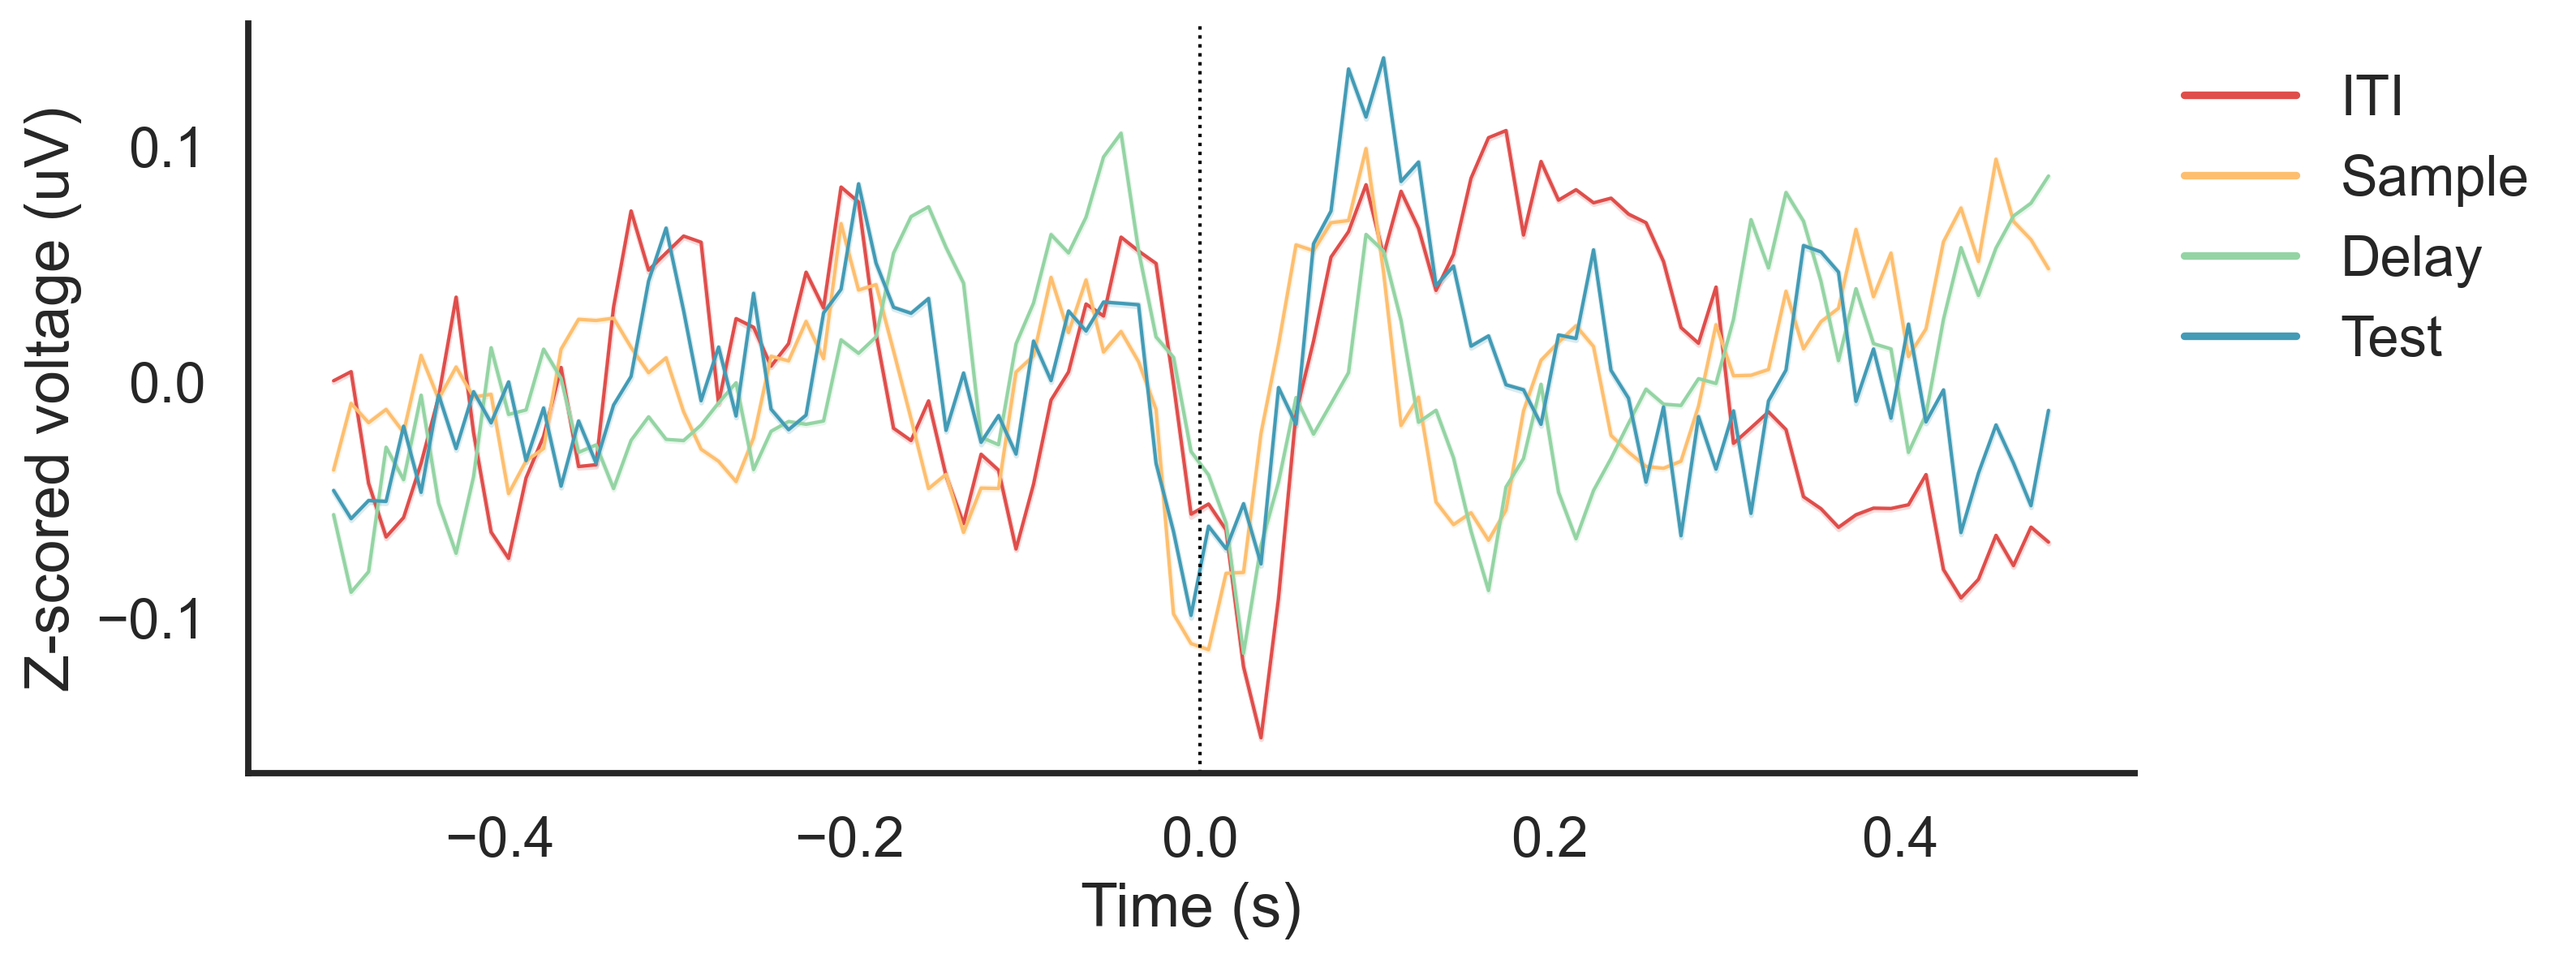

In [186]:
plot_avg_voltage(z_data, phase_palette, 'zscored_voltage')

In [187]:
plot_avg_voltage(data, phase_palette, 'voltage')

ValueError: Could not interpret value `bin_centres` for parameter `x`

<Figure size 3000x1200 with 0 Axes>

In [189]:
def plot_voltage_distributions(data, color, ycol):
    # Set style and context
    sns.set(context='talk', style='white')    
    # Create a figure
    plt.figure(dpi=300, figsize=(12, 5))

    # Plot the median line
    lineplot =sns.lineplot(
        data=data,
        x='bin_centres',
        y=ycol,
        hue='phase',
        hue_order=['ITI', 'Sample', 'Delay', 'Test'],
        estimator='median',
        errorbar = ('pi', 50),
        err_kws = {'alpha': .05,  'linewidth': 0 },
        linewidth=1,
        palette=color
    )

    # Improve labels
    plt.xlabel('Time (s)')
    plt.ylabel('Z-scored voltage (uV)')
    plt.xlim([-0.4,0.4])
    plt.xticks(rotation=0)
    plt.legend(frameon=False, bbox_to_anchor=(1.2, 1))
    

    # Add vertical bars to mark specific timepoints (SWR onset and others)
    plt.axvline(x=0, color='black', linestyle='dotted', linewidth=1)
    
    plt.axvline(x=-0.1,color='darkgray', linestyle='dotted', linewidth=1)
    plt.axvline(x=0.02, color='darkgray', linestyle='dotted', linewidth=1)
    #plt.axvline(x=0.1, color='darkgray', linestyle='dotted', linewidth=1)
    #plt.axvline(x=0.2, color='darkgray', linestyle='dotted', linewidth=1)    
    sns.despine()
    plt.show()

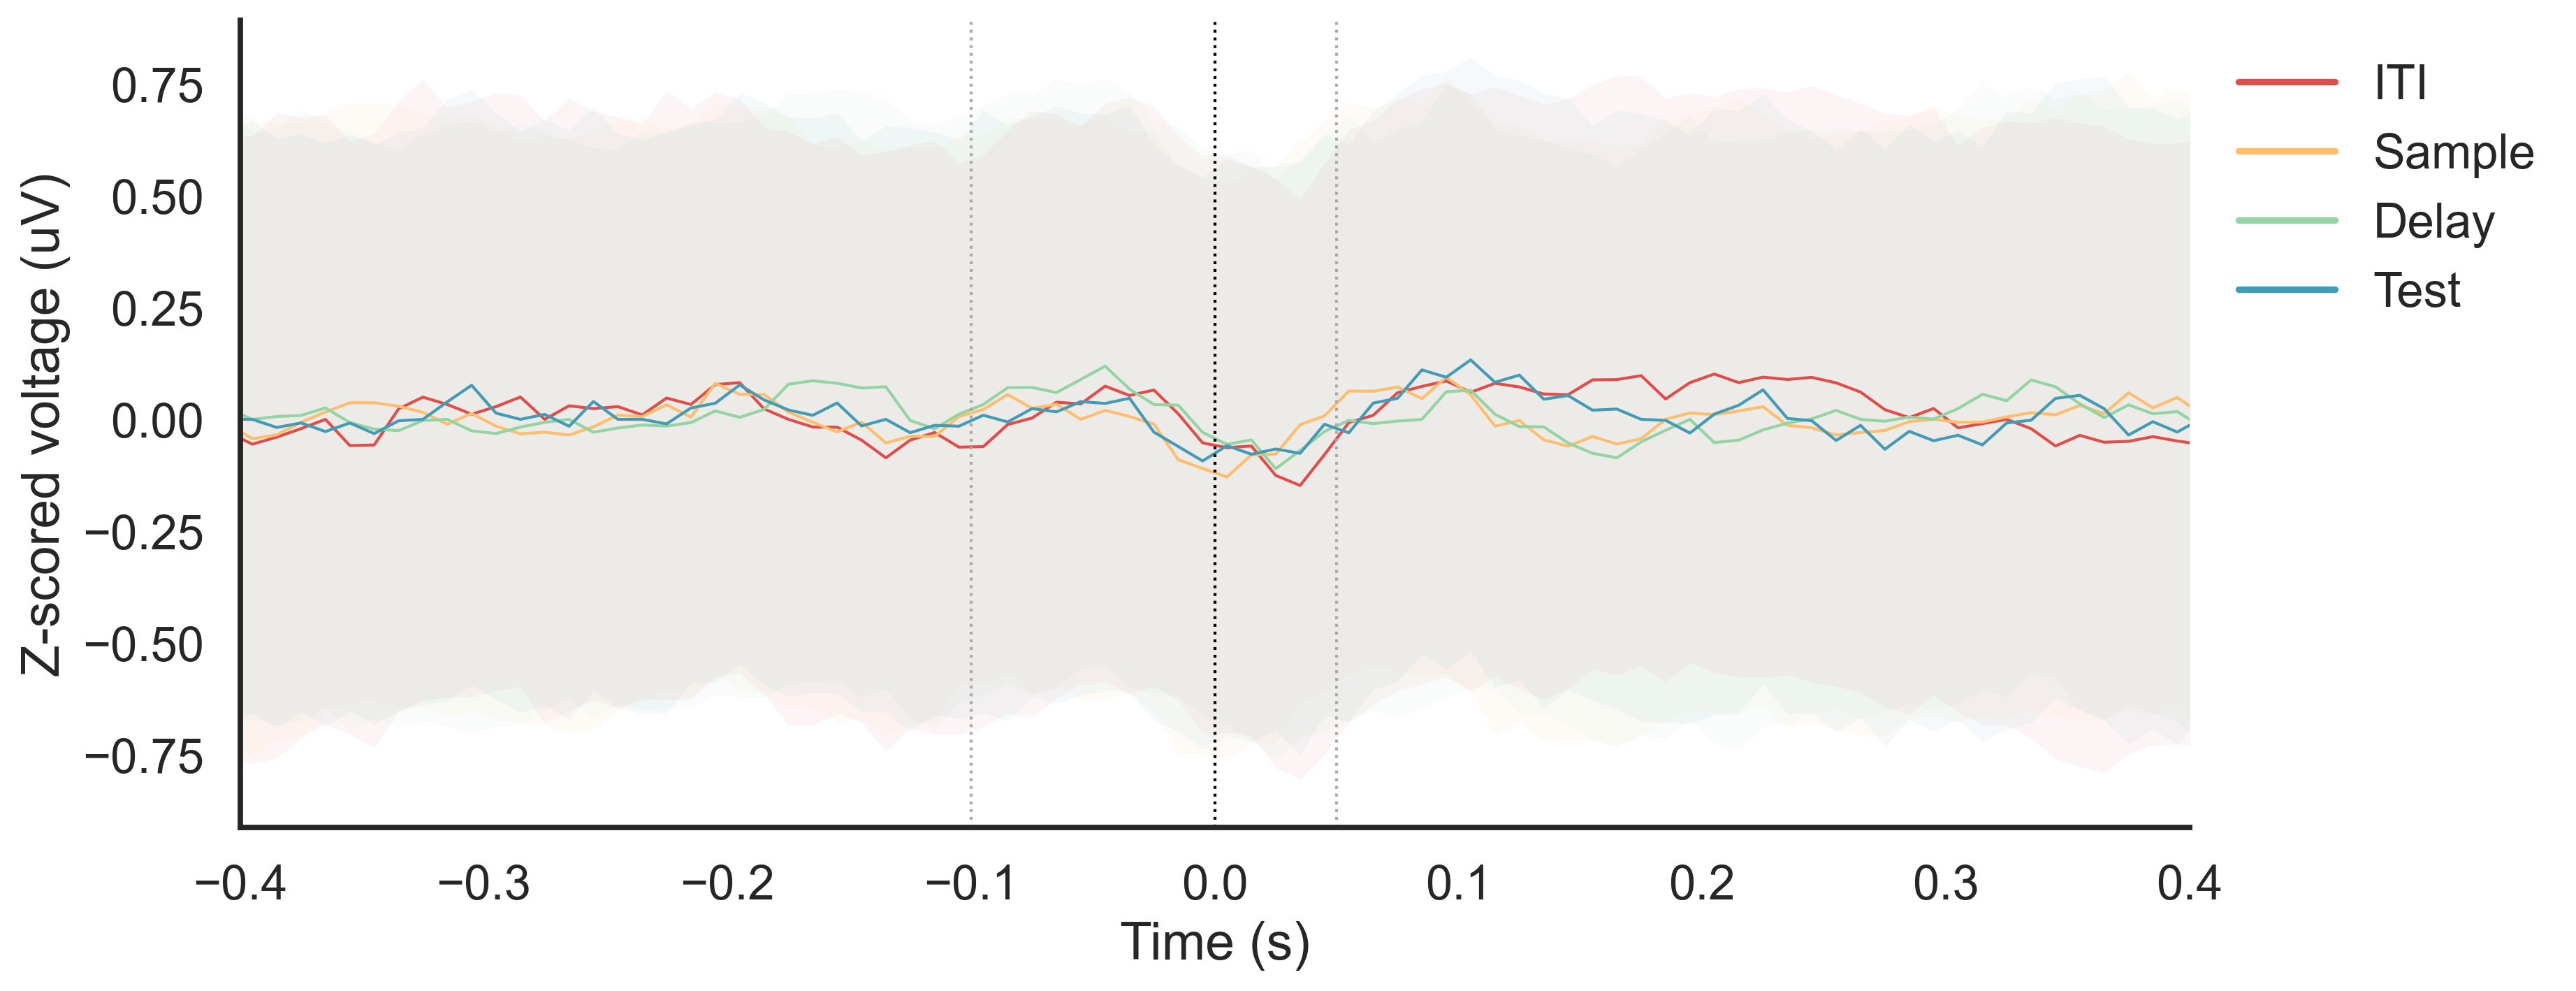

In [190]:
plot_voltage_distributions(z_data, phase_palette, 'zscored_voltage')

<br>

## Heatmap of average z-scored amplitude changes per ripple
Average across traces (tetrodes).

<br>

#### Pivot dataset for plot

In [106]:
heatmap_data = data.groupby(['phase', 'ripple_nr', 'bin_centres'])['zscored_voltage'].mean().reset_index()

In [107]:
# Step above creates all possible combinations of phase x ripple nr and adds NA if doesn't exist
heatmap_data = heatmap_data.dropna()

In [407]:
def plot_heatmap_data(data, phase, vmin, vmax, sigma=1):
    print(data[data['phase'] == phase]['zscored_voltage'].describe())
    
    # Filter data based on the phase, drop the 'phase' column, pivot, and shuffle   
    transformed_data = data[data['phase'] == phase].drop(
        'phase', axis=1).pivot(
        index='ripple_nr', 
        columns='bin_centres', 
        values='zscored_voltage').reset_index(drop=True).sample(frac=1)
    
    # Apply Gaussian smoothing
    smoothed_data = gaussian_filter(transformed_data, sigma=sigma)
    
    # Create the heatmap using smoothed data
    plt.figure(figsize=(12, 4))
    cmap = "inferno"
    
    # Add cbar_kws to include the color bar title
    sns.heatmap(smoothed_data, cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, robust=True, 
                cbar_kws={'label': 'Z-scored Voltage (uV)'})

    # Re-arrange y-tick labels
    plt.yticks(range(0, len(smoothed_data), 20), fontsize=15)

    # Set x-tick labels
    bins = [float(x/10) for x in range(-5, 6, 1)]
    plt.xlabel('Time (ms)')
    plt.ylabel('Trials (#)')
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99], bins, fontsize=15, rotation=0)  # Rotate x-tick labels horizontally

    # Add vertical line
    plt.axvline(50, linewidth=1.8, color='white', linestyle=':')
    plt.axvline(80, linewidth=1, color='lightgray', linestyle=':') )
    plt.axvline(100, linewidth=1, color='lightgray', linestyle=':') )
    plt.axvline(200, linewidth=1, color='lightgray', linestyle=':') )
       
    # Remove spines for a clean look
    sns.despine()

    # Show the plot
    plt.show()


count    29304.000000
mean         0.004459
std          0.604428
min         -2.166199
25%         -0.415594
50%          0.006667
75%          0.416122
max          2.349523
Name: zscored_voltage, dtype: float64


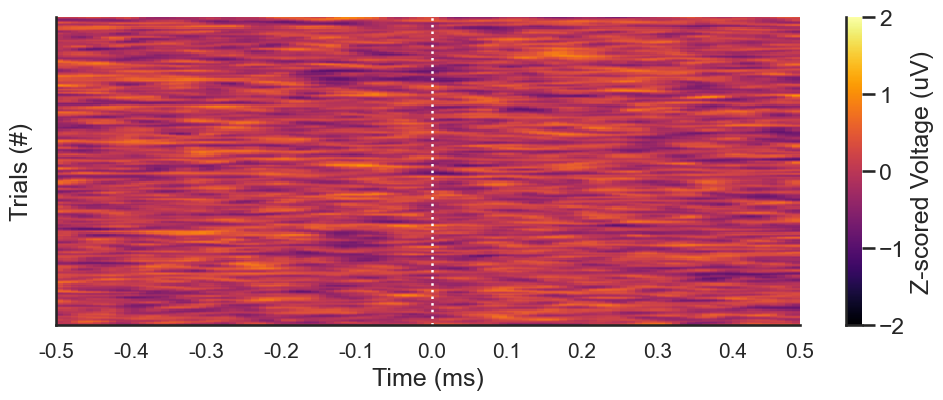

In [415]:
plot_heatmap_data(heatmap_data, 'ITI', -2, 2, sigma=1)

count    50985.000000
mean         0.009135
std          0.633389
min         -2.151985
25%         -0.426270
50%          0.004371
75%          0.447331
max          2.291312
Name: zscored_voltage, dtype: float64


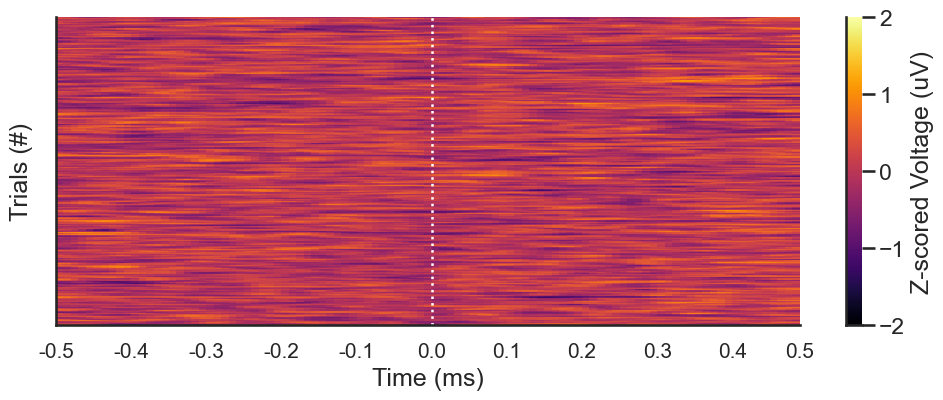

In [416]:
plot_heatmap_data(heatmap_data, 'Sample', -2, 2, sigma=1)

count    34254.000000
mean         0.003357
std          0.586848
min         -1.901733
25%         -0.394100
50%         -0.000194
75%          0.397881
max          2.575308
Name: zscored_voltage, dtype: float64


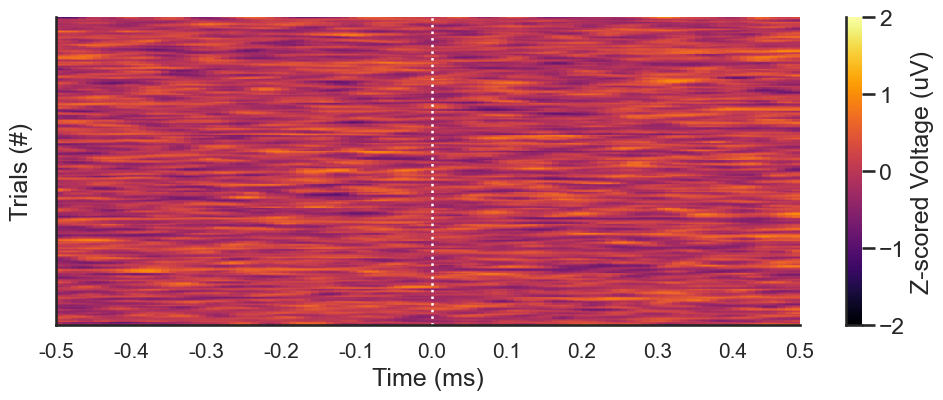

In [417]:
plot_heatmap_data(heatmap_data, 'Delay', -2, 2, 1)

count    41679.000000
mean         0.008204
std          0.613024
min         -2.173577
25%         -0.413494
50%          0.000572
75%          0.432176
max          2.326993
Name: zscored_voltage, dtype: float64


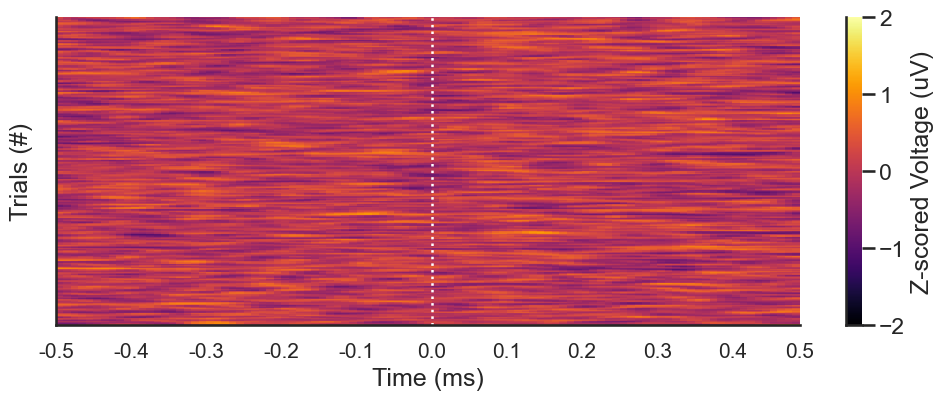

In [422]:
plot_heatmap_data(heatmap_data, 'Test', -2, 2, 1)

<br> 
<br>

## Comparing ERP windows

Pre-onset period baseline to  previous baseline period average
Post onset baselined to previous period average.

In [163]:
def calculate_and_plot_zscored_differences(data, comparisons, palette='viridis', bins = 60):
    # Initialize list for storing results
    results = []

    # Iterate through each unique phase
    for phase in data['phase'].unique():
        phase_data = data[data['phase'] == phase]

        # Pivot data to get each timepoint's zscored_voltage for each ripple_nr and TT
        pivoted_data = phase_data.pivot(index=['ripple_nr', 'TT'], columns='timepoint', values='zscored_voltage')

        # Calculate specified comparisons
        comparison_data = {}
        for comparison in comparisons:
            timepoint_1, timepoint_2 = comparison
            comparison_name = f'{timepoint_1}_vs_{timepoint_2}'
            comparison_data[comparison_name] = pivoted_data[timepoint_2] - pivoted_data[timepoint_1]
        
        # Convert comparison_data into a DataFrame
        comparison_df = pd.DataFrame(comparison_data)

        # Add phase column to comparison_df
        comparison_df['phase'] = phase

        # Append to results
        results.append(comparison_df)

    # Concatenate results from all phases
    results_df = pd.concat(results).reset_index()

    # Set histogram parameters
    bin_width = (results_df.iloc[:, 0].max() - results_df.iloc[:, 0].min()) / bins  # Assuming the first comparison column for bin width
    print(f'Bin width for histograms: {bin_width:.2f} uV')

    # Create histograms for each comparison
    plt.figure(dpi=300, figsize=(8, 4))  
    sns.set_context('talk')
    
    for i, comparison in enumerate(comparisons):
        comparison_name = f'{comparison[0]}_vs_{comparison[1]}'

        # Plot histogram for each comparison
        plt.subplot(len(comparisons), 1, i + 1)
        sns.histplot(data=results_df, x=comparison_name, 
                     hue='phase', bins=bins, palette=palette, stat='count', 
                     alpha=0.05, element='step', legend=False, linewidth=1.5)
        plt.title(f'{comparison[0]} vs. {comparison[1]} Differences')
        plt.xlabel('Z-scored Voltage (uV)')
        plt.ylabel('Count')
        sns.despine()
        
    plt.axvline(0, linestyle='dotted', color='black', linewidth=1)    
    plt.tight_layout()
    plt.show()

    # Cumulative quantile plot for each comparison
    for comparison in comparisons:
        comparison_name = f'{comparison[0]}_vs_{comparison[1]}'

        plt.figure(dpi=300, figsize=(6, 4))  # Shortened height
        sns.set_context('talk')
        
        sns.ecdfplot(data=results_df, x=comparison_name, hue='phase', palette=palette, linewidth=1.5, legend=False)
        plt.xlabel('Z-scored Voltage (uV)')
        plt.ylabel('Probability')
        plt.xlim([-2.5,2.5])

        # Add median vertical lines for each phase
        for i, phase in enumerate(results_df['phase'].unique()):
            median_value = results_df.loc[results_df['phase'] == phase, comparison_name].median()
            plt.axvline(median_value, linestyle='solid', color=palette[i], linewidth=1.2)
        
        plt.axvline(0, linestyle='dotted', color='black', linewidth=1)
        
        #plt.title(f'Cumulative Quantile Plot for {comparison[0]} vs. {comparison[1]} Differences')
        sns.despine()
        plt.show()

    return results_df

In [167]:
# given exclusion period is 500 ms and I want to avoid any post-ripple effects from potential previous events
z_data.loc[(z_data.bin_centres >= -0.1) & (z_data.bin_centres < 0), 'timepoint'] = 'Baseline'

# Informed by average changes in amplitude (30ms dip, 100 ms peak, 200 ms ITI-specific)
z_data.loc[(z_data.relative_timestamp > 0) & (z_data.relative_timestamp <= 0.05), 'timepoint'] = '0-50 ms' 


In [168]:
window_data = z_data.groupby(['phase', 'ripple_nr', 'TT','timepoint'])['zscored_voltage'].mean().reset_index()           

Bin width for histograms: 30.33 uV


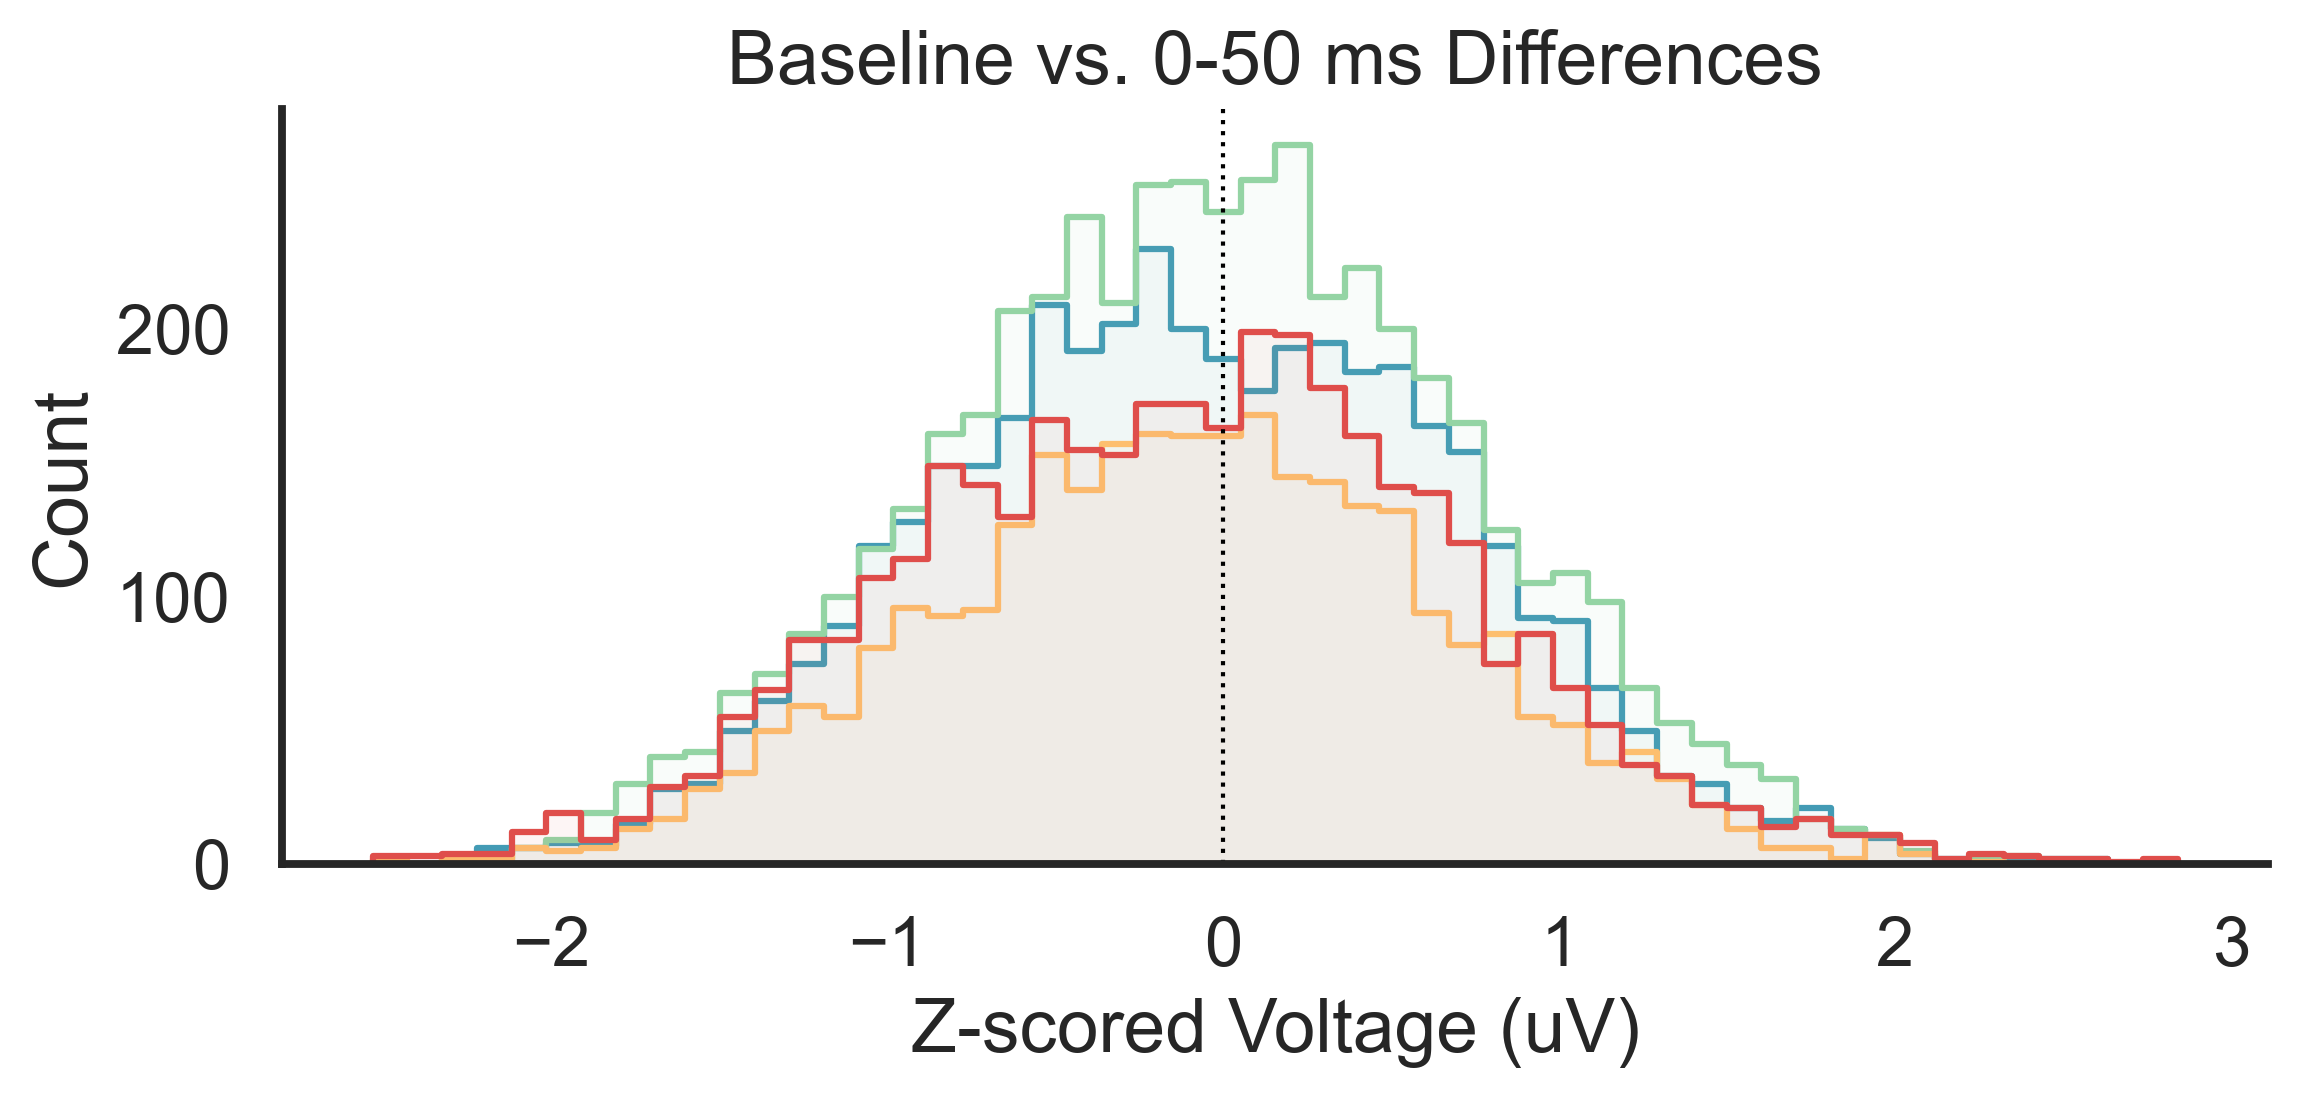

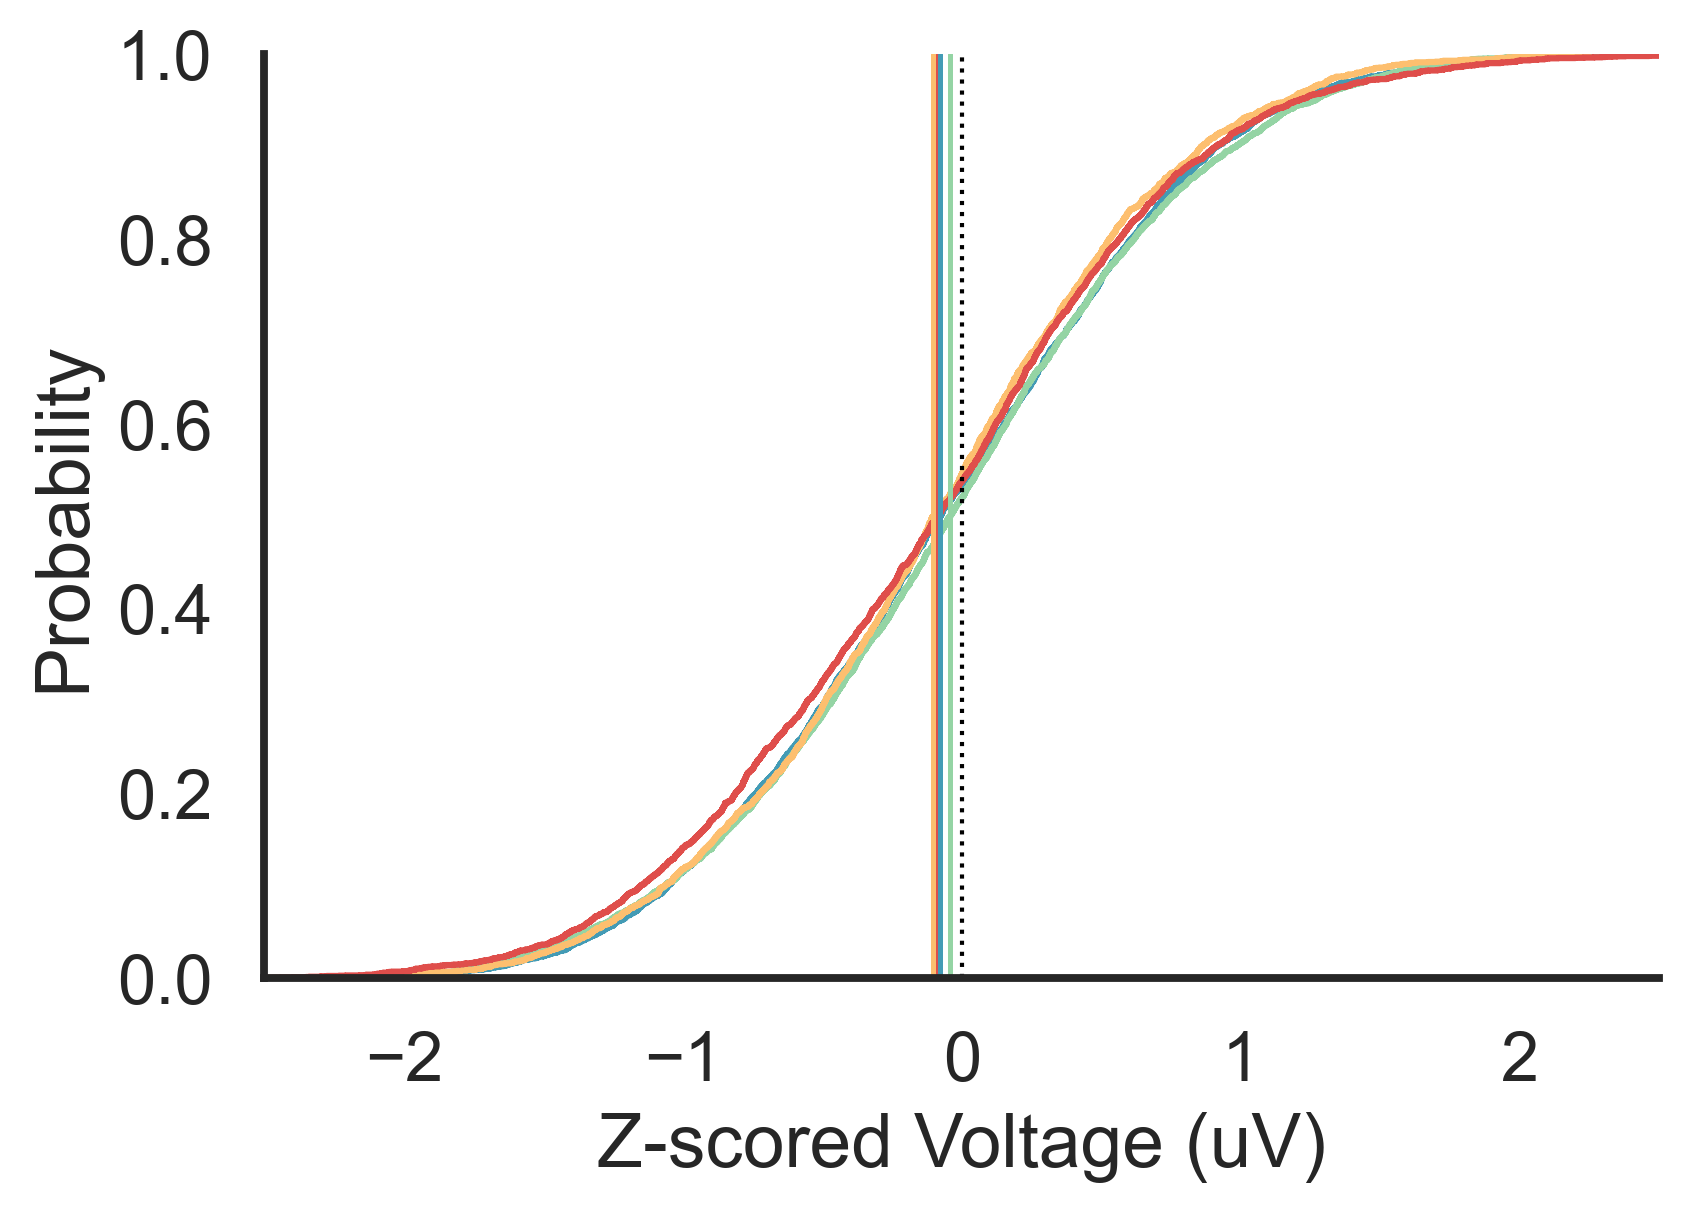

In [169]:
# Define the comparisons you want to make
comparisons = [('Baseline', '0-50 ms')]

timepoint_differences = calculate_and_plot_zscored_differences(
    window_data, palette=phase_palette, comparisons=comparisons, bins=52
)

In [173]:
timepoint_differences.groupby(['phase'])['Baseline_vs_0-50 ms'].describe()    

,count,mean,std,min,25%,50%,75%,max
phase,,,,,,,,
Delay,3648.0,-0.103837,0.808938,-2.531181,-0.687393,-0.084275,0.440953,2.840352
ITI,2970.0,-0.092086,0.743315,-2.472944,-0.589162,-0.101977,0.415687,2.244136
Sample,4905.0,-0.045443,0.778754,-2.527636,-0.584844,-0.043122,0.484881,2.385562
Test,4137.0,-0.058352,0.768492,-2.211918,-0.602667,-0.077296,0.489492,2.769629


## Statistical testing
Compare Baseline vs. Pre vs. Post to determine effect of time/swr onset within and across phases

In [175]:
import scipy.stats as stats

for phase in ['ITI', 'Sample', 'Delay', 'Test']:
    # Extract the differences for the current phase
    data = timepoint_differences.loc[timepoint_differences.phase == phase, 'Baseline_vs_0-50 ms']
    
    # Perform the Shapiro-Wilk test for normality
    stat, p = stats.shapiro(data)
    
    print('{}: stat={}, p={}'.format(phase, stat, p))


ITI: stat=0.9992546439170837, p=0.2719250023365021
Sample: stat=0.9986377954483032, p=0.00036294650635682046
Delay: stat=0.9982783198356628, p=0.0005426941206678748
Test: stat=0.9979161620140076, p=2.317892540304456e-05


In [188]:
import scipy.stats

# Assuming 'timepoint_differences' is your DataFrame
for phase in ['ITI', 'Sample', 'Delay', 'Test']:
    data = timepoint_differences.loc[timepoint_differences.phase == phase, 'Baseline_vs_0-50 ms']
    
    # Perform Wilcoxon signed-rank test
    wilcoxon_stat, wilcoxon_p = scipy.stats.wilcoxon(data)
    
    # Perform paired t-test
    t_stat, t_p = scipy.stats.ttest_rel(data, [0] * len(data))  # Assuming you want to compare against zero
    
    # Print results
    print(f'{phase} : Wilcoxon stat={wilcoxon_stat}, p={wilcoxon_p}, paired t-test stat={t_stat}, p={t_p}')


ITI : Wilcoxon stat=1899672.0, p=5.612666911198007e-11, paired t-test stat=-6.751453518106548, p=1.7536588744988047e-11
Sample : Wilcoxon stat=5618304.0, p=6.082937757184212e-05, paired t-test stat=-4.0868653887642115, p=4.4422852106041376e-05
Delay : Wilcoxon stat=2834477.0, p=8.777188833235612e-15, paired t-test stat=-7.752919375522087, p=1.1566706150745666e-14
Test : Wilcoxon stat=3887839.0, p=3.3807954267938056e-07, paired t-test stat=-4.883844587667032, p=1.0796789345730881e-06


##### THE END